# Querying On-Disk Tables

> Objectives:
> * Compare queries of tabular data for **on-disk** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.035 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 35.004 MiB


## Load movielens datasets in pandas DataFrames

In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.027 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 35.031 MiB


In [3]:
# Import CSV files via pandas
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 68.766 MiB RAM in 0.591s, peaked 6.285 MiB above current, total RAM usage 103.797 MiB


In [4]:
# Store movies and ratings in 2 separate tables in SQLite
sqlite_norm = "movielens-norm.sqlite"
if os.path.exists(sqlite_norm):
    os.unlink(sqlite_norm)
import sqlite3
conn = sqlite3.connect(sqlite_norm)
conn.text_factory = str   # Shut up problems with Unicode
ratings.to_sql("ratings", conn)
movies.to_sql("movies", conn)
conn.close()

In [4] used 121.320 MiB RAM in 4.229s, peaked 122.727 MiB above current, total RAM usage 225.117 MiB


In [5]:
# create one merged DataFrame
lens = pd.merge(movies, ratings)

In [5] used 85.203 MiB RAM in 0.105s, peaked 0.000 MiB above current, total RAM usage 310.320 MiB


In [6]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [6] used 61.137 MiB RAM in 0.181s, peaked 0.000 MiB above current, total RAM usage 371.457 MiB


In [7]:
# Store lens denormalized in 1 table in SQLite
sqlite_denorm = "movielens-denorm.sqlite"
if os.path.exists(sqlite_denorm):
    os.unlink(sqlite_denorm)
conn_denorm = sqlite3.connect(sqlite_denorm)
conn_denorm.text_factory = str   # Shut up problems with Unicode
lens.to_sql("lens", conn_denorm)
conn_denorm.close()

In [7] used 38.457 MiB RAM in 5.216s, peaked 108.090 MiB above current, total RAM usage 409.914 MiB


In [8]:
# Get rid of unnecessary containers to save memory
del movies, ratings

In [8] used 0.012 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 409.926 MiB


In [9]:
%time result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 42.4 ms


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [9] used 0.215 MiB RAM in 0.054s, peaked 0.000 MiB above current, total RAM usage 410.141 MiB


In [10]:
# keep the run-time for reference
qtime_pandas_mem = mw.measurements.time_delta
qtime_pandas_mem

0.054290056228637695

In [10] used -0.008 MiB RAM in 0.003s, peaked 0.012 MiB above current, total RAM usage 410.133 MiB


## Querying on-disk data with SQLite (relational database)

In [11]:
# Execute the query with the de-normalized SQLite database
conn = sqlite3.connect(sqlite_denorm)
c = conn.cursor()

In [11] used 0.008 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 410.141 MiB


In [12]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
%time result = [r for r in c.execute(q)]

CPU times: user 104 ms, sys: 44 ms, total: 148 ms
Wall time: 146 ms
In [12] used 0.000 MiB RAM in 0.148s, peaked 0.000 MiB above current, total RAM usage 410.141 MiB


In [13]:
# keep the run-time for reference
qtime_sqlite_denorm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [13] used 0.004 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 410.145 MiB


In [14]:
# Execute the query with the normalized SQLite database
conn = sqlite3.connect(sqlite_norm)
c = conn.cursor()

In [14] used 0.000 MiB RAM in 0.013s, peaked 0.000 MiB above current, total RAM usage 410.145 MiB


In [15]:
q = """
select ratings.user_id from movies 
INNER JOIN ratings ON movies.movie_id = ratings.movie_id
where movies.title == 'Tom and Huck (1995)' and ratings.rating == 5
"""
%time result = [r for r in c.execute(q)]

CPU times: user 392 ms, sys: 40 ms, total: 432 ms
Wall time: 425 ms
In [15] used 0.000 MiB RAM in 0.428s, peaked 0.000 MiB above current, total RAM usage 410.145 MiB


In [16]:
# keep the run-time for reference
qtime_sqlite_norm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [16] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 410.145 MiB


So in general, we see that it is much faster to query tables in denormalized form, although they take much more storage:

In [17]:
!ls -lh $sqlite_norm $sqlite_denorm

-rw-r--r-- 1 faltet faltet 78M abr  4 13:20 movielens-denorm.sqlite
-rw-r--r-- 1 faltet faltet 37M abr  4 13:20 movielens-norm.sqlite
In [17] used 0.293 MiB RAM in 0.194s, peaked 0.000 MiB above current, total RAM usage 410.438 MiB


In some way, storing tables in normalized form is a kind of compression, but that comes to the cost of using more time to process queries.  Let's enter another way to compress denormalized data tables on-disk:

## bcolz

`bcolz` cannot only deal with data in-memory, but also on-disk using exactly the same API.  Let's try that.

In [18]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5
bcolz.set_nthreads(4)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.0.0rc2
NumPy version:     1.10.4
Blosc version:     1.8.0 ($Date:: 2016-03-31 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.5.1
Python version:    2.7.11 |Continuum Analytics, Inc.| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


4

In [18] used 5.523 MiB RAM in 0.049s, peaked 0.000 MiB above current, total RAM usage 415.961 MiB


In [19]:
# Import a pandas DataFrame in a ctable on-disk
bcolz_dir = "movielens-denorm.bcolz"
if os.path.exists(bcolz_dir):
    import shutil
    shutil.rmtree(bcolz_dir)
zlens = bcolz.ctable.fromdataframe(lens, rootdir=bcolz_dir)

In [19] used 2.176 MiB RAM in 0.347s, peaked 78.219 MiB above current, total RAM usage 418.137 MiB


In [20]:
%time result = zlens["(title == b'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result

CPU times: user 312 ms, sys: 16 ms, total: 328 ms
Wall time: 177 ms


array([  75, 3842, 6031])

In [20] used 0.336 MiB RAM in 0.181s, peaked 0.000 MiB above current, total RAM usage 418.473 MiB


In [21]:
# keep the run-time for reference
qtime_bcolz = mw.measurements.time_delta
# ...and print the result (for reference too)
result

array([  75, 3842, 6031])

In [21] used 0.023 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 418.496 MiB


In [22]:
# One can optimize the query more
%time result = [r.user_id for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]

CPU times: user 224 ms, sys: 8 ms, total: 232 ms
Wall time: 143 ms
In [22] used 0.004 MiB RAM in 0.145s, peaked 0.000 MiB above current, total RAM usage 418.500 MiB


In [23]:
# keep the run-time for reference
qtime_bcolz_opt = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [23] used 0.008 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 418.508 MiB


Let's see the space consumed on-disk:

In [24]:
!du -sh $bcolz_dir

6,7M	movielens-denorm.bcolz
In [24] used 0.016 MiB RAM in 0.114s, peaked 0.000 MiB above current, total RAM usage 418.523 MiB


and let's compare it with the internal estimated size:

In [25]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 8.01 MB; ratio: 19.16
  cparams := cparams(clevel=5, shuffle=1, cname='lz4')
  rootdir := 'movielens-denorm.bcolz'
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [25] used 2.012 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 420.535 MiB


So, the internal estimated size is a bit higher than the actual size on-disk, which means that bcolz offers a conservative guess in general.

Another interesting fact is that the de-normalized version of the ctable takes less space than the normalized version in a relational database, and the query speed is still faster (than SQLite at least).

But there are other ways to store compressed tables.  Let's visit PyTables and see how it performs.

## PyTables

In [26]:
h5denorm = "movielens-denorm.h5"
if os.path.exists(h5denorm):
    os.unlink(h5denorm)
zlens.tohdf5(h5denorm, nodepath='/h5lens')

In [26] used 0.777 MiB RAM in 0.615s, peaked 0.000 MiB above current, total RAM usage 421.312 MiB


In [27]:
import tables
h5file = tables.open_file(h5denorm)
h5lens = h5file.root.h5lens

In [27] used 0.074 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 421.387 MiB


In [28]:
# Let's have a look at the HDF5 table
h5lens

/h5lens (Table(1000209,), shuffle, blosc:lz4(5)) ''
  description := {
  "movie_id": Int64Col(shape=(), dflt=0, pos=0),
  "title": StringCol(itemsize=82, shape=(), dflt='', pos=1),
  "genres": StringCol(itemsize=47, shape=(), dflt='', pos=2),
  "user_id": Int64Col(shape=(), dflt=0, pos=3),
  "rating": Int64Col(shape=(), dflt=0, pos=4),
  "unix_timestamp": Int64Col(shape=(), dflt=0, pos=5)}
  byteorder := 'little'
  chunkshape := (1628,)

In [28] used 0.000 MiB RAM in 0.101s, peaked 0.000 MiB above current, total RAM usage 421.387 MiB


In [29]:
%time result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

CPU times: user 216 ms, sys: 4 ms, total: 220 ms
Wall time: 193 ms
In [29] used 0.016 MiB RAM in 0.195s, peaked 0.000 MiB above current, total RAM usage 421.402 MiB


In [30]:
# keep the run-time for reference
qtime_pytables = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [30] used 0.023 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 421.426 MiB


So, it seems that PyTables has a similar performance than SQLite for the queries (200 ms vs 170 ms for the denormalized case).  What about the size of the HDF5 file?

In [31]:
h5file.close()
!ls -lh $h5denorm

-rw-rw-r-- 1 faltet faltet 6,5M abr  4 13:20 movielens-denorm.h5
In [31] used 0.004 MiB RAM in 0.116s, peaked 0.000 MiB above current, total RAM usage 421.430 MiB


6.5 MB is very close to 6.6 MB that used bcolz (which is expected because both are using LZ4 as the compressor), and both are much less than pandas and SQLite.

Now, pandas comes with its own interface to PyTables via the HDFStore sub-package, and we are curious to see how it fares compared with the native PyTables approach.  Let's check that out.

## HDFStore (pandas HDF5 via PyTables)

In [32]:
h5pandas = "movielens-pandas.h5"
if os.path.exists(h5pandas):
    os.unlink(h5pandas)
from pandas import HDFStore
hdf = HDFStore(h5pandas, complevel=5, complib="blosc")
hdf.put('h5lens', lens, format='table', data_columns=True)

In [32] used -2.453 MiB RAM in 11.097s, peaked 125.625 MiB above current, total RAM usage 418.977 MiB


In [33]:
%time hdf.select('h5lens', where="(title == 'Tom and Huck (1995)') & (rating == 5)", columns=["user_id"])

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 20.9 ms


,user_id
5121,75
5164,3842
5187,6031


In [33] used 0.062 MiB RAM in 0.027s, peaked 0.000 MiB above current, total RAM usage 419.039 MiB


In [34]:
# keep the run-time for reference
qtime_pandas_hdf5 = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [34] used 0.031 MiB RAM in 0.016s, peaked 0.000 MiB above current, total RAM usage 419.070 MiB


As we can see, the time (26 ms) is almost 2x better than to the time that it takes the query on a pandas DataFrame in memory (44 ms).  What about the size on-disk?

In [35]:
hdf.close()

In [35] used 2.016 MiB RAM in 0.183s, peaked 0.000 MiB above current, total RAM usage 421.086 MiB


In [36]:
!ls -lh $h5pandas

-rw-rw-r-- 1 faltet faltet 13M abr  4 13:20 movielens-pandas.h5
In [36] used -3.980 MiB RAM in 0.117s, peaked 0.000 MiB above current, total RAM usage 417.105 MiB


Ok, so 13 MB is around 2x larger than a pure PyTables file with the same info (6.5 MB).  Where the overhead comes from?  Well, it turns out that pandas makes use of the indexing capabilities of PyTables automatically, so let's make PyTables to index the columns that participate in the query.

## Indexing (PyTables)

In [37]:
## Copy the original PyTables table into another file
import shutil
h5idx = "movielens-indexed.h5"
if os.path.exists(h5idx):
    os.unlink(h5idx)
shutil.copyfile(h5denorm, h5idx)

In [37] used 0.000 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 417.105 MiB


In [38]:
# Open the new file in 'a'ppend mode
h5i = tables.open_file(h5idx, mode="a")

In [38] used 0.004 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 417.109 MiB


In [39]:
# Create an index for the 'title' column
h5lens = h5i.root.h5lens
h5lens.cols.title.create_csindex()

1000209

In [39] used 0.012 MiB RAM in 4.424s, peaked 161.797 MiB above current, total RAM usage 417.121 MiB


In [40]:
# ...and redo the query...
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loop, best of 1: 4.6 ms per loop
In [40] used 0.008 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 417.129 MiB


In [41]:
# keep the run-time for reference
qtime_pytables_index1 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [41] used 0.004 MiB RAM in 0.059s, peaked 0.000 MiB above current, total RAM usage 417.133 MiB


So, by indexing one column we have got a 60x of acceleration wrt PyTables (5 ms vs 300 ms).  What happens if we index the 'rating' column?

In [42]:
h5lens.cols.rating.create_csindex()

1000209

In [42] used 0.051 MiB RAM in 0.849s, peaked 0.000 MiB above current, total RAM usage 417.184 MiB


In [43]:
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loop, best of 1: 1.47 ms per loop
In [43] used 0.020 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 417.203 MiB


In [44]:
# keep the run-time for reference
qtime_pytables_index2 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [44] used 0.000 MiB RAM in 0.042s, peaked 0.000 MiB above current, total RAM usage 417.203 MiB


Ok, that's another ~8x additional acceleration, and the best time that we ever reached for this query.

In [45]:
h5i.close()

In [45] used 0.020 MiB RAM in 0.101s, peaked 0.000 MiB above current, total RAM usage 417.223 MiB


## Indexing (SQLite)

We are of course curious to find out how indexing in relational databases fares against PyTables' own indexing.  Let's check that out:

In [46]:
sqlite_idx = "movielens-indexed.sqlite"
if os.path.exists(sqlite_idx):
    os.unlink(sqlite_idx)
shutil.copyfile(sqlite_denorm, sqlite_idx)
conn_idx = sqlite3.connect(sqlite_idx)

In [46] used -0.070 MiB RAM in 0.083s, peaked 0.000 MiB above current, total RAM usage 417.152 MiB


In [47]:
c = conn_idx.cursor()
c.execute("CREATE INDEX index_title ON lens (title)")
conn_idx.commit()

In [47] used 0.000 MiB RAM in 2.707s, peaked 30.707 MiB above current, total RAM usage 417.152 MiB


In [48]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]
# keep the run-time for reference
qtime_sqlite_index1 = t.best

1 loop, best of 1: 181 µs per loop
In [48] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 417.152 MiB


In [49]:
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [49] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 417.152 MiB


Wow, with quite less than 1 ms we are getting the best figure so far, and faster than the best figure with indexed PyTables.

## Exercise

What will happen if index the rating column?  We should get better speed, right?  Try it out and report the improvement that you are seeing.

### Solution

In [50]:
c.execute("CREATE INDEX index_rating ON lens (rating)")
conn_idx.commit()

In [50] used 0.000 MiB RAM in 0.726s, peaked 7.328 MiB above current, total RAM usage 417.152 MiB


In [51]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]

1 loop, best of 1: 134 ms per loop
In [51] used 0.004 MiB RAM in 0.137s, peaked 0.000 MiB above current, total RAM usage 417.156 MiB


Uh, we are getting far worse performance with 2 indexes. Take away lesson: indexing is a tricky thing and the best way to assess the improvement in performance is by trying it out, so do not blindly index everthing.

## Final performance comparison

In [52]:
%matplotlib inline

In [52] used 7.242 MiB RAM in 0.106s, peaked 0.000 MiB above current, total RAM usage 424.398 MiB


/home/faltet/miniconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/faltet/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


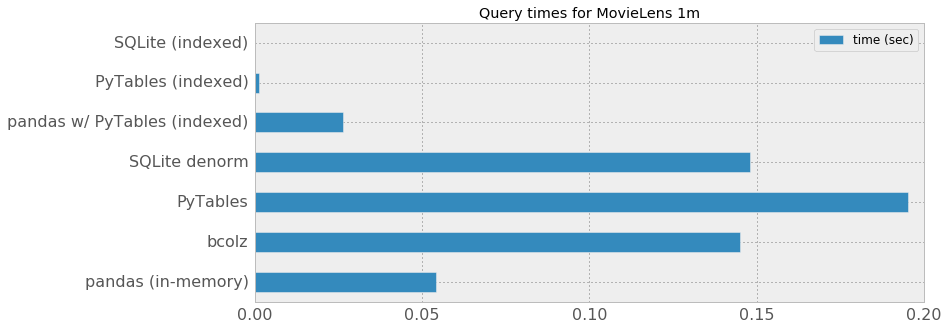

In [53] used -24.395 MiB RAM in 0.422s, peaked 24.438 MiB above current, total RAM usage 400.004 MiB


In [53]:
# Query times
labels = ["pandas (in-memory)", "bcolz", "PyTables", "SQLite denorm", "pandas w/ PyTables (indexed)", "PyTables (indexed)", "SQLite (indexed)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas_mem, qtime_bcolz_opt, qtime_pytables, qtime_sqlite_denorm, qtime_pandas_hdf5, qtime_pytables_index2, qtime_sqlite_index1]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m")

## Final size comparison

In [54]:
!du -sh movielens* | sort -n

5,8M	movielens-1m
6,5M	movielens-denorm.h5
6,7M	movielens-denorm.bcolz
11M	movielens-indexed.h5
13M	movielens-pandas.h5
37M	movielens-norm.sqlite
78M	movielens-denorm.sqlite
119M	movielens-indexed.sqlite
In [54] used 0.000 MiB RAM in 0.120s, peaked 0.000 MiB above current, total RAM usage 400.004 MiB


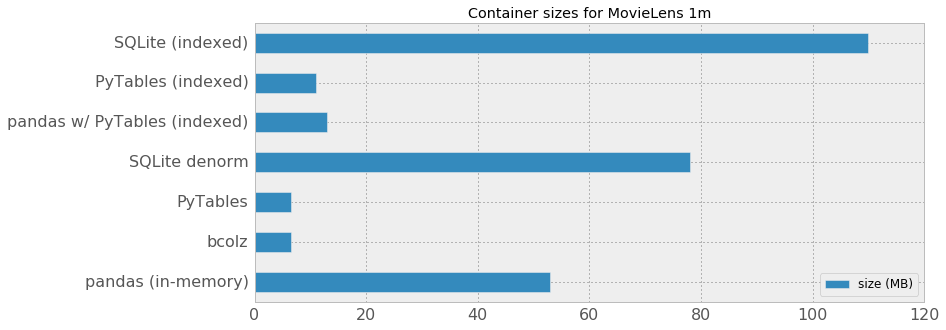

In [55] used 1.027 MiB RAM in 0.301s, peaked 0.000 MiB above current, total RAM usage 401.031 MiB


In [55]:
# Container sizes
df = pd.DataFrame({'size (MB)': [53, 6.6, 6.5, 78, 13, 11, 110]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

# Final Overview

Fortunately, there are many different solutions for storing large datasets both in-memory and on-disk.  Here it is a summary of the ones that we have seen in this tutorial:

* In-core
  * Python lists and dictionaries: Included in Python.  Very flexible.  Not efficient for large datasets.
  * NumPy: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * Pandas: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * bcolz: Good for large amounts of data, but reduced functionality.  Supports compression.
  
* Out-of-core
  * Pandas/HDFStore: Good for large datasets.  Supports indexing and compression.  Medium query speeds.
  * PyTables: Good for large datasets.  Supports indexing and compression.  Good query speeds.
  * bcolz: Good for large datasets.  Supports compression, but not indexing.  Medium query speeds.
  * SQLite: Can be used for large datasets, but requires lots of storage.  Supports indexing.  Excellent query speeds.

As you see, every solution has strengths and weaknesses, with wild variations in resource consumptions, so a wise thing to do is to know them better and try to apply the best candidate to your scenario.

Hope that helped and **enjoy data**.